In [39]:
from mgefit import mge_fit_1d
import numpy as np
import matplotlib.pyplot as plt

In [156]:
SQRT_TOW_PI = np.sqrt(2*np.pi)

def gNFW(r):
    rho = rho_s*((r/rs)**gamma)*(0.5 + 0.5*r/rs)**(-gamma - 3)
    return rho

def deprojection(mge2d, inc, shape):
        '''
        Return the 3D deprojected MGE coefficients
        '''
        mge3d = np.zeros_like(mge2d)
        if shape == 'oblate':
            qintr = mge2d[:, 2]**2 - np.cos(inc)**2
            if np.any(qintr <= 0):
                raise RuntimeError('Inclination too low q < 0')
            qintr = np.sqrt(qintr)/np.sin(inc)
            if np.any(qintr < 0.05):
                raise RuntimeError('q < 0.05 components')
            dens = mge2d[:, 0]*mge2d[:, 2] /\
                (mge2d[:, 1]*qintr*SQRT_TOW_PI)
            mge3d[:, 0] = dens
            mge3d[:, 1] = mge2d[:, 1]
            mge3d[:, 2] = qintr
        elif shape == 'prolate':
            qintr = np.sqrt(1.0/mge2d[:, 2]**2 -
                            np.cos(inc)**2)/np.sin(inc)
            if np.any(qintr > 10):
                raise RuntimeError('q > 10.0 conponents')
            sigmaintr = mge2d[:, 1]*mge2d[:, 2]
            dens = mge2d[:, 0] / (SQRT_TOW_PI*mge2d[:, 1] *
                                       mge2d[:, 2]**2*qintr)
            mge3d[:, 0] = dens
            mge3d[:, 1] = sigmaintr
            mge3d[:, 2] = qintr
        return mge3d
def luminosityDensity(mge3d, R, z):
        '''
        Return the luminosity density at coordinate R, z (in L_solar/pc^3)
        '''
        rst = 0.0
        ngauss = mge3d.shape[0]
        for i in range(ngauss):
            rst += mge3d[i, 0] * np.exp(-0.5/mge3d[i, 1]**2 *
                                        (R**2 + (z/mge3d[i, 2])**2))
        return rst

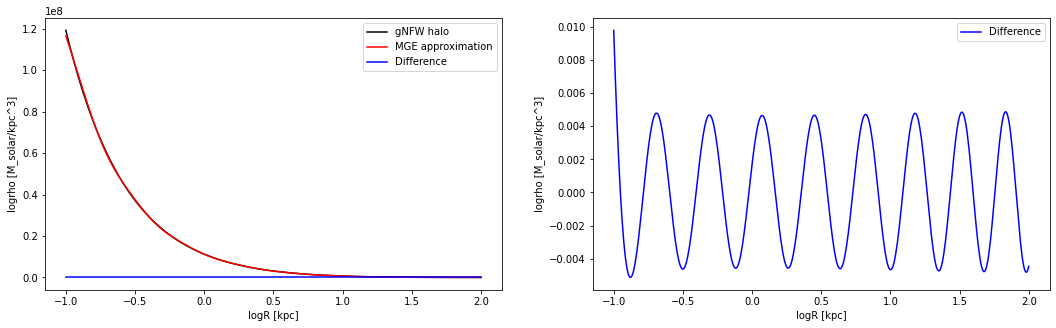

In [242]:
r = np.logspace(np.log10(0.1), np.log10(100), 500) #Cria valores espaçados em de um delta-log (requerido para o mge1d_fit). Unidade de Kpc
logr = np.log10(r) #Unidade de Kpc

#Definindo os parâmetros do gNFW
gamma = -1.0  # usually between [-2.0, 0.0]
rs = 30     # [kpc]
rho_s = 1e5   # [M_solar/kpc^2]  (1[M_solar/kpc^3] = 1e9[M_solar/pc^3])

profile_DM = np.log10(gNFW(r)) #Calculando o perfil gNFW analítico e tomando o log para posterior plot

#Agora vamos realizar a parametrização em MGE 1d
r_mge2d = np.logspace(np.log10(0.1), np.log10(200), 200) #Cria valores espaçados em de um delta-log (requerido para o mge1d_fit)
rho_mge2d = gNFW(r_mge2d) #Perfil gNFW

#-------------Aqui é onde realmente começa a parametrização MGE--------------------------------
#Como demos o rs em [kpc], é necessário converter para [pc], multiplicando os valores de r por 1e3.
#De maneira similar, devemos converter a densidadde de [M_sol/kpc³] para [M_sol/pc³], dividindo rho_mge2d por 1e9

mge = mge_fit_1d.mge_fit_1d(r_mge2d*1e3, rho_mge2d/1e9, ngauss=10,quiet=True)
mge_peak = mge.sol[0]         #Pico de cada gaussiana
mge_sigma = mge.sol[1]        #Sigma de cada gaussiana
#O resultado acima já está em M_sun/pc²

mge2d = np.zeros((len(mge_peak), 3)) #Agora iremos criar um array com o número de linhas igual ao número de
                                        #gaussianas e três colunas para armazenar os dados
mge2d[:, 0] = mge_peak     #Pico de cada gaussiana
mge2d[:, 1] = mge_sigma    #Sigma de cada gausiana
mge2d[:, 2] = 1            #qObs d cada gaussiana. Aqui estamos assumindo halos de DM esféricos


#Here are some unit conversion
mge3d = deprojection(mge2d=mge2d, inc=np.pi/2, shape='oblate' )#Deprojeta o perfil 2d para 3d assumindo uma inclinação inc e um formato do elipsoide de velocidades 
mge_density = luminosityDensity(mge3d,r*1e3,0) #Densidade das MGE deprojetadas. Atenção as unidades de medida. Multiplicamos por 1e3 para ter unidade de pc

#Finalmente o perfil DM parametrizado pelo MGE.
profile_mge = np.log10(mge_density*1e9)#Aqui voltamos a multiplicar por 1e9 pois queremos comparar com o outro perfil, que tem unidades [M_sol/pc³]

# plot the density profile of the dark halo and the mge approximation

plt.figure(figsize=(18,5))
plt.subplot(121)
line_dh, = plt.plot(logr, 10**profile_DM, 'k')
line_mge, = plt.plot(logr, 10**profile_mge, 'r')
diff, = plt.plot(logr, profile_DM-profile_mge, 'b', scalex=200)
plt.xlabel('logR [kpc]')
plt.ylabel('logrho [M_solar/kpc^3]')
plt.legend([line_dh, line_mge, diff], ['gNFW halo', 'MGE approximation', 'Difference'])


plt.subplot(122)
diff, = plt.plot(logr, profile_DM-profile_mge, 'b', scalex=200)
plt.xlabel('logR [kpc]')
plt.ylabel('logrho [M_solar/kpc^3]')
plt.legend([diff], ['Difference'])

plt.subplots_adjust(wspace=0.2)
plt.savefig('/home/carlos/JAM/tests/testes/DM_profile.png', fmt='png')

plt.show()